# <font color="#CA3532">Explicabilidad de redes neuronales</font>

En este notebook se muestra un ejemplo de explicabilidad de redes neuronales mediante el uso de gradientes. Los gradientes no solo se utilizan para entrenar los modelos de Deep Learning, sino que también pueden ser utilizados para explicar las decisiones de los mismos. En concreto, en este notebook se explora un dataset de riesgo financiero para la aprobación de préstamos: **Loan Approval Classification Dataset**

https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

<hr>

En el notebook se desarrolla el código por completo según una fase sencilla de preprocesamiento de los datos, el entrenamiento de un modelo de red neuronal y la explicabilidad de dicho modelo utilizando **Gradient x Input**.

In [7]:
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub

## <font color="#CA3532">Carga de los datos del problema</font>

En estas celdas se carga el dataset completo, descargado de Kaggle.

In [8]:
# Download latest version
path = kagglehub.dataset_download("taweilo/loan-approval-classification-data")

print("Path to dataset files:", path)

Path to dataset files: /home/christian/.cache/kagglehub/datasets/taweilo/loan-approval-classification-data/versions/1


### <font color="#CA3532">Primer vistazo de los datos</font>

En las próximas celdas se comprueba que no hay datos faltantes y el aspecto que tienen los datos.

In [9]:
data = pd.read_csv(path + "/loan_data.csv")
data

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [11]:
data.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [12]:
data.isna().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

## <font color="#CA3532">Preprocesamiento</font>

Comienza la fase de preprocesamiento. Para ello, se analiza atributo a atributo qué distribución tienen los datos.

### <font color="#CA3532">Person Age</font>

La edad del cliente que solicita un préstamo.

In [13]:
variable = data["person_age"]

<Axes: >

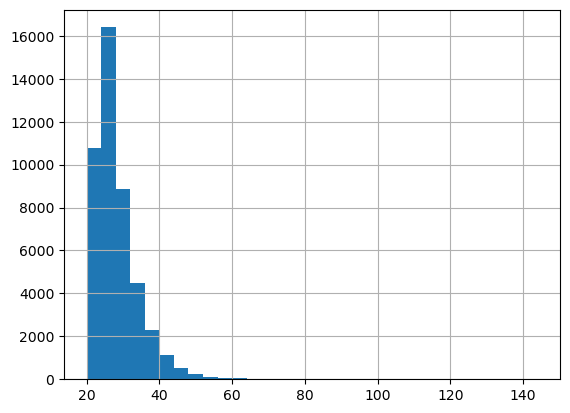

In [14]:
variable.hist(bins=31)

Viendo el aspecto de cola-larga que tiene la edad, lo primero que se puede plantear es hacer un *clipping* para ajustar el valor máximo.

<Axes: >

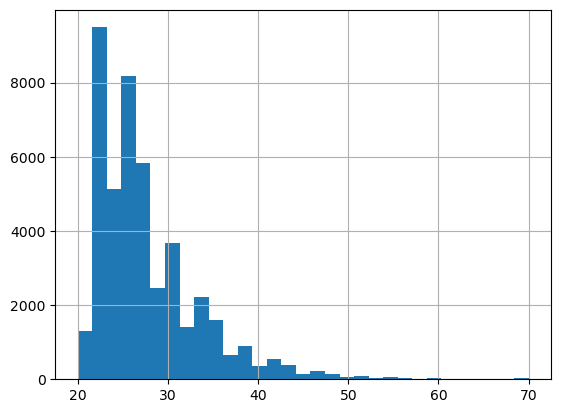

In [15]:
variable = np.clip(variable, 0, 70)
variable.hist(bins=31)

Luego, parece razonable aplicar el logaritmo para eliminar la distribución long-tail a algo más razonable.

<Axes: >

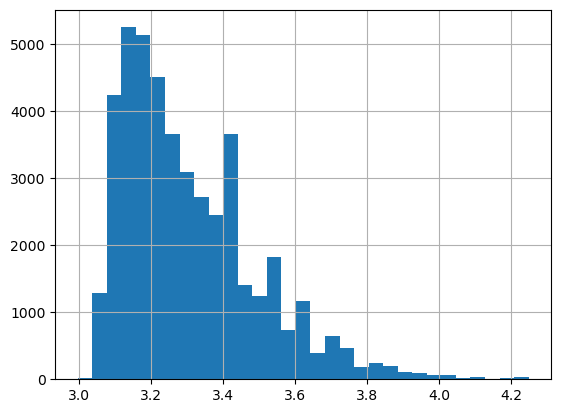

In [16]:
variable = np.log(variable)
variable.hist(bins=31)

### <font color="#CA3532">Person Income</font>

Ingreso anual del cliente.

<Axes: >

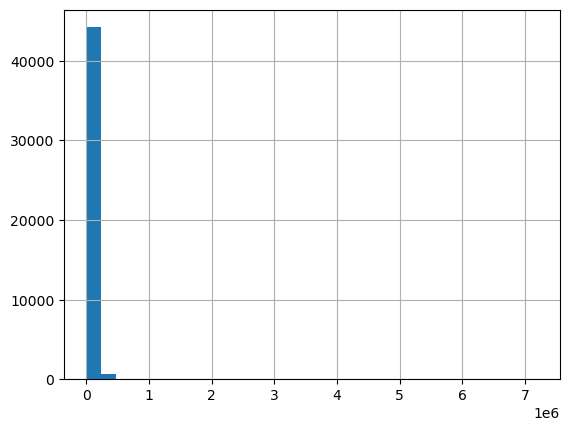

In [17]:
variable = data["person_income"]
variable.hist(bins=31)

Claramente es una long-tail por definición. Por tanto, se aplica el logaritmo.

<Axes: >

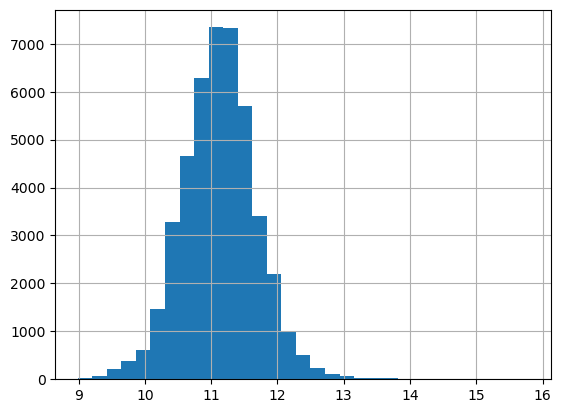

In [18]:
np.log(variable).hist(bins=31)

### <font color="#CA3532">Person Emp Exp</font>

Años de experiencia de trabajo.

<Axes: >

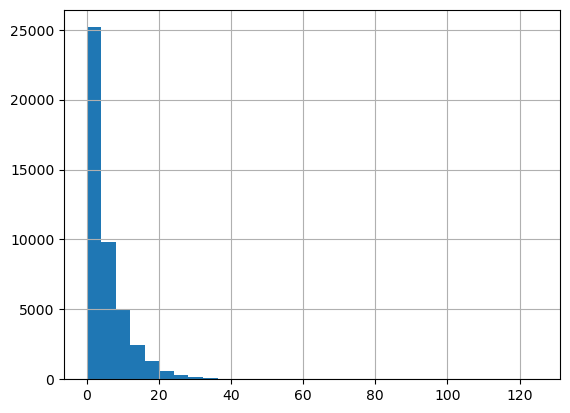

In [19]:
variable = data["person_emp_exp"]
variable.hist(bins=31)

Una vez más, es una long-tail, por lo que se va a aplicar el logaritmo. Sin embargo, como hay valores que son 0, se suma uno a toda la distribución para evitar $-\infty$.

<Axes: >

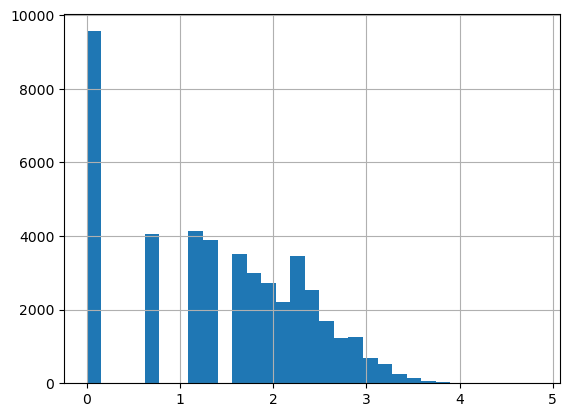

In [20]:
variable = np.log(variable+1)
variable.hist(bins=31)

### <font color="#CA3532">Person Home Ownership</font>

Situación de propiedad de la vivienda. Los únicos valores posibles son RENT (alquiler), OWN (propiedad), MORTGAGE (hipoteca) y OTHER (otro). Por tanto, pasamos a dummies.

In [21]:
variable = data["person_home_ownership"]
variable.unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [22]:
pd.get_dummies(variable, prefix="person_home_ownership_")

,person_home_ownership__MORTGAGE,person_home_ownership__OTHER,person_home_ownership__OWN,person_home_ownership__RENT
0,0,0,0,1
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
44995,0,0,0,1
44996,0,0,0,1
44997,0,0,0,1
44998,0,0,0,1


### <font color="#CA3532">Loan Amnt</font>

Valor del préstamo solicitado por el cliente.

<Axes: >

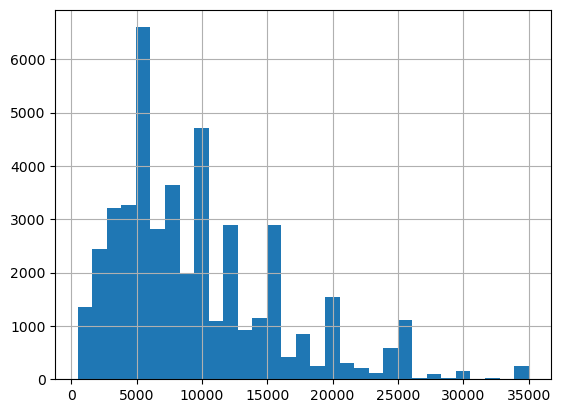

In [23]:
variable = data["loan_amnt"]
variable.hist(bins=31)

Esta distribución parece bastante razonable y podría utilizarse tal cual, sin embargo aplicamos también el logaritmo por intentar tener una normal.

<Axes: >

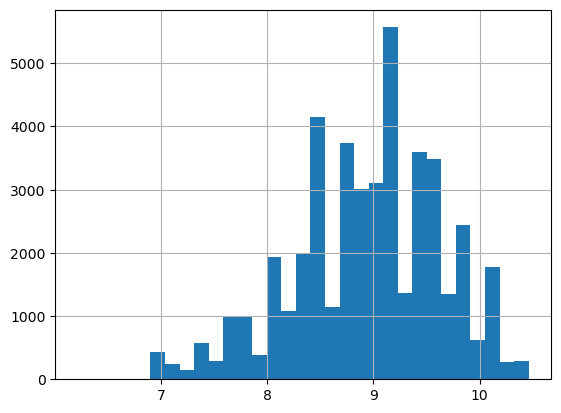

In [24]:
variable = np.log(variable)
variable.hist(bins=31)

### <font color="#CA3532">Loan Intent</font>

Finalidad del préstamo. Tiene un conjunto finito de valores: PERSONAL (personal), EDUCATION (educación), VENTURE (médico), HOMEIMPROVEMENT (mejora del hogar) y DEBTCONSOLIDATION (consolidación de deudas). Por tanto, pasamos a dummies.

In [25]:
variable = data["loan_intent"]
variable.unique()

array(['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT',
       'DEBTCONSOLIDATION'], dtype=object)

In [26]:
pd.get_dummies(variable, prefix="loan_intent_")

,loan_intent__DEBTCONSOLIDATION,loan_intent__EDUCATION,loan_intent__HOMEIMPROVEMENT,loan_intent__MEDICAL,loan_intent__PERSONAL,loan_intent__VENTURE
0,0,0,0,0,1,0
1,0,1,0,0,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
44995,0,0,0,1,0,0
44996,0,0,1,0,0,0
44997,1,0,0,0,0,0
44998,0,1,0,0,0,0


### <font color="#CA3532">Loan Int Rate</font>

Tipo de interés del préstamo. Tiene una distribución más que razonable, por lo que no se modifica.

<Axes: >

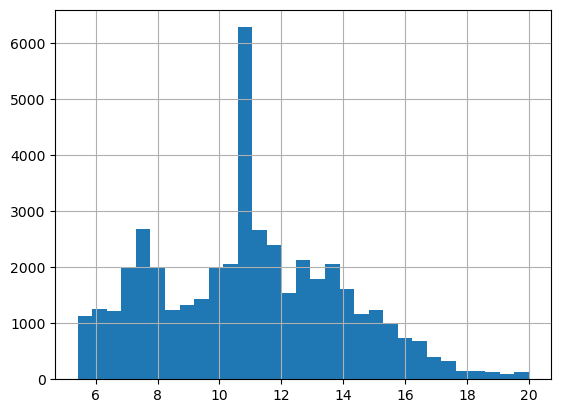

In [27]:
variable = data["loan_int_rate"]
variable.hist(bins=31)

### <font color="#CA3532">Loan Percent Income</font>

Importe del préstamo como porcentaje de los ingresos anuales.

<Axes: >

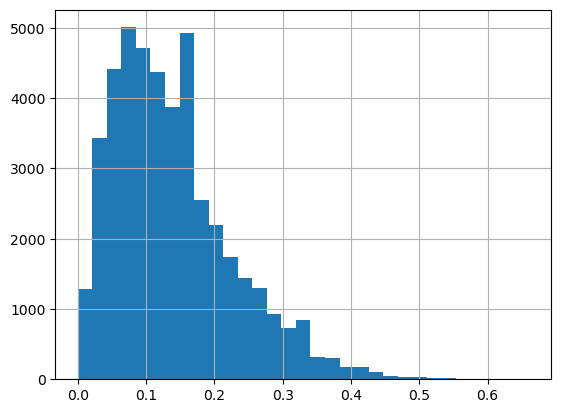

In [28]:
variable = data["loan_percent_income"]
variable.hist(bins=31)

Tiene una distribución bastante razonable. Sin embargo, aplicamos un logaritmo para intentar encontrar esa normal.

<Axes: >

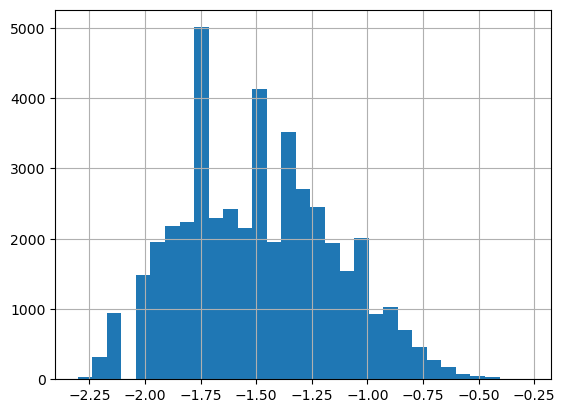

In [29]:
variable = np.log(variable+1e-1)
variable.hist(bins=31)

### <font color="#CA3532">Cb Person Cred Hist Length</font>

Duración del crédito en años.

<Axes: >

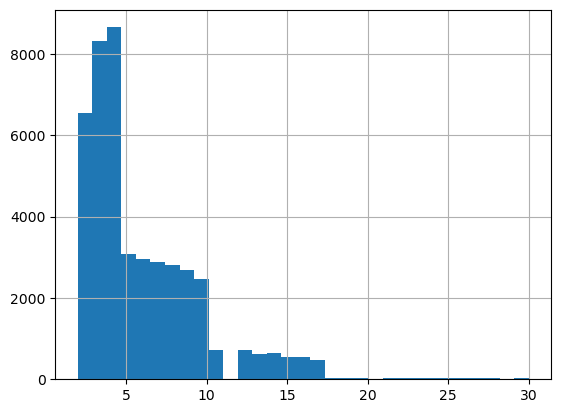

In [30]:
variable = data["cb_person_cred_hist_length"]
variable.hist(bins=31)

Es una distribución extraña y muy alejada en sus valores. Aplicamos un logaritmo por agrupar datos.

<Axes: >

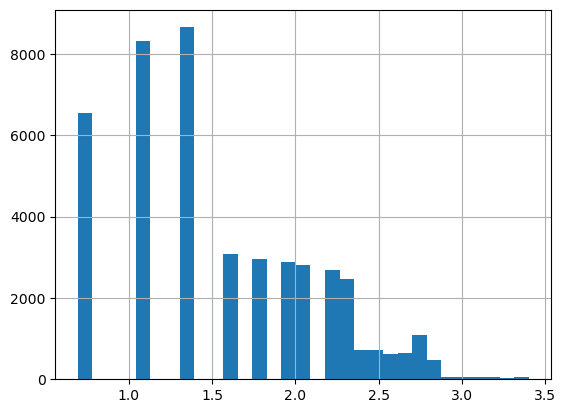

In [31]:
variable = np.log(variable)
variable.hist(bins=31)

### <font color="#CA3532">Credit Score</font>

Credit score del cliente en el banco. Sigue una distribución más que razonable.

<Axes: >

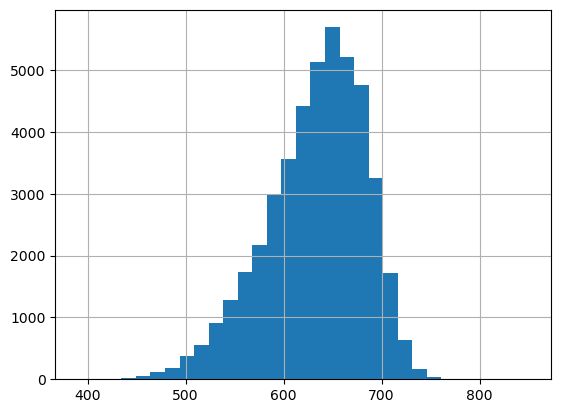

In [32]:
variable = data["credit_score"]
variable.hist(bins=31)

### <font color="#CA3532">Previous Loan Defaults on File</font>

Indicador de impagos de préstamos anteriores.

In [33]:
variable = data["previous_loan_defaults_on_file"]
variable.unique()

array(['No', 'Yes'], dtype=object)

In [34]:
variable.replace({"No": 0, "Yes": 1})

0        0
1        1
2        0
3        0
4        0
        ..
44995    0
44996    0
44997    0
44998    0
44999    0
Name: previous_loan_defaults_on_file, Length: 45000, dtype: int64

### <font color="#CA3532">TODO JUNTO</font>

Después de todo el análisis, se aplica la transformación de los datos.

In [35]:
data["person_age"] = np.log(np.clip(data["person_age"], 0, 70))
data["person_gender"] = data["person_gender"].replace({"female":0, "male":1})
data["person_education"] = data["person_education"].replace({"High School":0, "Associate":1, "Bachelor":2, "Master":3, "Doctorate":4})
data["person_income"] = np.log(data["person_income"])
data["person_emp_exp"] = np.log(data["person_emp_exp"]+1)
data = pd.concat((data, pd.get_dummies(data["person_home_ownership"], prefix="person_home_ownership_")), axis=1)
data = data.drop(columns=["person_home_ownership"])
data["loan_amnt"] = np.log(data["loan_amnt"])
data = pd.concat((data, pd.get_dummies(data["loan_intent"], prefix="loan_intent_")), axis=1)
data = data.drop(columns=["loan_intent"])
data["loan_percent_income"] = np.log(data["loan_percent_income"]+0.1)
data["cb_person_cred_hist_length"] = np.log(data["cb_person_cred_hist_length"])
data["previous_loan_defaults_on_file"] = data["previous_loan_defaults_on_file"].replace({"No": 0, "Yes": 1})

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   person_age                       45000 non-null  float64
 1   person_gender                    45000 non-null  int64  
 2   person_education                 45000 non-null  int64  
 3   person_income                    45000 non-null  float64
 4   person_emp_exp                   45000 non-null  float64
 5   loan_amnt                        45000 non-null  float64
 6   loan_int_rate                    45000 non-null  float64
 7   loan_percent_income              45000 non-null  float64
 8   cb_person_cred_hist_length       45000 non-null  float64
 9   credit_score                     45000 non-null  int64  
 10  previous_loan_defaults_on_file   45000 non-null  int64  
 11  loan_status                      45000 non-null  int64  
 12  person_home_owners

In [37]:
data

,person_age,person_gender,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,...,person_home_ownership__MORTGAGE,person_home_ownership__OTHER,person_home_ownership__OWN,person_home_ownership__RENT,loan_intent__DEBTCONSOLIDATION,loan_intent__EDUCATION,loan_intent__HOMEIMPROVEMENT,loan_intent__MEDICAL,loan_intent__PERSONAL,loan_intent__VENTURE
0,3.091042,0,3,11.183699,0.000000,10.463103,16.02,-0.527633,1.098612,561,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,0,0,9.415890,0.000000,6.907755,11.14,-1.714798,0.693147,504,...,0,0,1,0,0,1,0,0,0,0
2,3.218876,0,0,9.428512,1.386294,8.612503,12.87,-0.616186,1.098612,635,...,1,0,0,0,0,0,0,1,0,0
3,3.135494,0,2,11.286690,0.000000,10.463103,15.23,-0.616186,0.693147,675,...,0,0,0,1,0,0,0,1,0,0
4,3.178054,1,3,11.099453,0.693147,10.463103,14.27,-0.462035,1.386294,586,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,3.295837,1,1,10.778352,1.945910,9.615805,15.66,-0.891598,1.098612,645,...,0,0,0,1,0,0,0,1,0,0
44996,3.610918,0,1,11.094375,2.890372,9.104980,14.07,-1.427116,2.397895,621,...,0,0,0,1,0,0,1,0,0,0
44997,3.496508,1,1,10.949788,2.079442,7.926964,10.02,-1.897120,2.302585,668,...,0,0,0,1,1,0,0,0,0,0
44998,3.367296,1,2,10.409220,1.609438,9.392662,13.23,-0.776529,1.791759,604,...,0,0,0,1,0,1,0,0,0,0


## <font color="#CA3532">Separación en TRAIN-TEST</font>

Ahora que se han transformado los datos, hay que separar en train-test.

In [38]:
X = data.drop(columns=["loan_status"])
y = data["loan_status"]

In [39]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## <font color="#CA3532">Normalización</font>

Una vez tenemos train y test, normalizamos los datos con media y std de train.

In [40]:
means = X_train_raw.mean()
stds = X_train_raw.std()
X_train = (X_train_raw-means) / stds
X_test = (X_test_raw-means) / stds

In [41]:
X_train.describe()

,person_age,person_gender,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,...,person_home_ownership__MORTGAGE,person_home_ownership__OTHER,person_home_ownership__OWN,person_home_ownership__RENT,loan_intent__DEBTCONSOLIDATION,loan_intent__EDUCATION,loan_intent__HOMEIMPROVEMENT,loan_intent__MEDICAL,loan_intent__PERSONAL,loan_intent__VENTURE
count,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,...,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04
mean,-2.044587e-15,-8.092292e-18,3.088887e-17,-1.318254e-15,-4.144833e-18,-1.299504e-15,1.139681e-15,1.340163e-16,-2.197748e-16,-6.506400e-16,...,-8.990339e-17,1.973730e-19,7.065953e-17,1.028313e-16,6.710681e-17,1.302662e-17,2.171103e-17,5.279727e-18,-2.072416e-17,6.118562e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.634282e+00,-1.106582e+00,-1.288573e+00,-3.820060e+00,-1.480771e+00,-3.838885e+00,-1.867012e+00,-2.348392e+00,-1.469157e+00,-4.827681e+00,...,-8.352804e-01,-5.251197e-02,-2.660026e-01,-1.041224e+00,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
25%,-6.664523e-01,-1.106582e+00,-1.288573e+00,-6.451277e-01,-7.631502e-01,-5.969609e-01,-8.101133e-01,-8.153795e-01,-7.966108e-01,-6.094639e-01,...,-8.352804e-01,-5.251197e-02,-2.660026e-01,-1.041224e+00,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
50%,-2.415560e-01,9.036589e-01,-3.606891e-01,-1.742892e-02,1.854926e-01,6.478053e-02,2.628404e-03,-7.049805e-02,-3.194316e-01,1.466317e-01,...,-8.352804e-01,-5.251197e-02,-2.660026e-01,9.603814e-01,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
75%,5.180761e-01,9.036589e-01,5.671948e-01,6.186931e-01,7.940326e-01,6.646859e-01,6.782409e-01,7.276121e-01,8.302939e-01,7.435493e-01,...,1.197169e+00,-5.251197e-02,-2.660026e-01,9.603814e-01,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
max,5.015846e+00,9.036589e-01,2.422962e+00,8.343544e+00,3.526269e+00,2.142782e+00,3.009438e+00,3.394679e+00,3.022695e+00,4.325055e+00,...,1.197169e+00,1.904275e+01,3.759257e+00,9.603814e-01,2.298147e+00,1.969081e+00,2.905366e+00,2.068821e+00,2.229352e+00,2.186582e+00


In [42]:
X_train.shape, y_train.shape

((36000, 21), (36000,))

## <font color="#CA3532">Construcción y entrenamiento del modelo</font>

Una vez se dispone de los datos preprocesados, construimos el modelo. La única particularidad es que se introduce regularización L1 en la capa de entrada para intentar hacer una selección de atributos.

In [63]:
def build_model(input_dim, hidden_size, output_dim, optimizer="Adam", l1reg=0.0):
    input_layer = tf.keras.layers.Input(shape=(input_dim,))
    dense_layer = tf.keras.layers.Dense(hidden_size, activation="tanh",
                                        kernel_regularizer=tf.keras.regularizers.l1(l1reg))(input_layer)
    dense_layer = tf.keras.layers.Dense(hidden_size, activation="relu")(dense_layer)
    output_layer = tf.keras.layers.Dense(output_dim, activation="softmax")(dense_layer)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [64]:
input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

hidden_size = 20
l1reg = 0.01 # AJUSTA EL NIVEL DE L1 EN LA ENTRADA PARA FILTRAR MAS O MENOS ATRIBUTOS
learning_rate = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model = build_model(input_dim, hidden_size, output_dim, optimizer=optimizer, l1reg=l1reg)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense_12 (Dense)            (None, 20)                440       
                                                                 
 dense_13 (Dense)            (None, 20)                420       
                                                                 
 dense_14 (Dense)            (None, 2)                 42        
                                                                 
Total params: 902 (3.52 KB)
Trainable params: 902 (3.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
282/282 [==============================] - 1s 2ms/step - loss: 0.7717 - accuracy: 0.8561
Epoch 2/50
282/282 [==============================] - 1s 2ms/step - loss: 0.3071 - accuracy: 0.8953
Epoch 3/50
282/282 [==============================] - 1s 2ms/step - loss: 0.2603 - accuracy: 0.8957
Epoch 4/50
282/282 [==============================] - 1s 2ms/step - loss: 0.2518 - accuracy: 0.8955
Epoch 5/50
282/282 [==============================] - 1s 2ms/step - loss: 0.2471 - accuracy: 0.8968
Epoch 6/50
282/282 [==============================] - 1s 2ms/step - loss: 0.2420 - accuracy: 0.8979
Epoch 7/50
282/282 [==============================] - 1s 2ms/step - loss: 0.2374 - accuracy: 0.9014
Epoch 8/50
282/282 [==============================] - 1s 2ms/step - loss: 0.2332 - accuracy: 0.9020
Epoch 9/50
282/282 [==============================] - 1s 2ms/step - loss: 0.2288 - accuracy: 0.9056
Epoch 10/50
282/282 [==============================] - 1s 2ms/step - loss: 0.2267 - accuracy: 0.9061

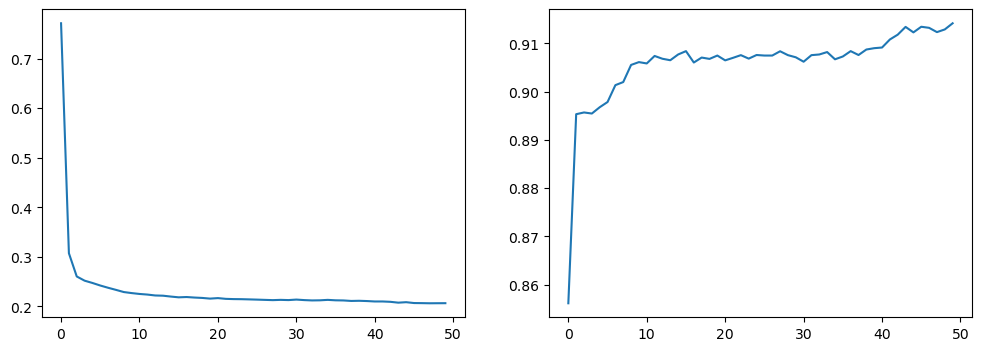

In [65]:
h = model.fit(X_train, y_train, batch_size=128, epochs=50)
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(h.history["loss"])
plt.subplot(1,2,2)
plt.plot(h.history["accuracy"])
plt.show()

In [66]:
model.evaluate(X_test, y_test)

282/282 [==============================] - 0s 1ms/step - loss: 0.2053 - accuracy: 0.9142


[0.20531709492206573, 0.914222240447998]

## <font color="#CA3532">Explicabilidad del modelo</font>

Representemos una red neuronal completa con Graphviz.

In [67]:
from graphviz import Digraph

def draw_network(inputs, hidden, outputs, color_input=None, input_names=None):
    # Crear un grafo dirigido
    dot = Digraph(comment='Ejemplo de Grafo Dirigido')
    dot.attr(rankdir='LR')
    
    if input_names is None:
        input_names = [str(i+1) for i in range(inputs)]

    # Agregar nodos
    for i in range(inputs):
        if color_input == i+1:
            dot.node('x'+str(i+1), input_names[i], color="red")
            dot.node("i"+str(i+1), "", shape="point", style='invis')
            dot.edge("i"+str(i+1), "x"+str(i+1), color="red")
        else:
            dot.node('x'+str(i+1), input_names[i])
            dot.node("i"+str(i+1), "", shape="point", style='invis')
            dot.edge("i"+str(i+1), "x"+str(i+1))
        
    for i in range(hidden):
        dot.node('h1_'+str(i+1), 'h1_'+str(i+1))
        dot.node('h2_'+str(i+1), 'h2_'+str(i+1))
        
    for i in range(outputs):
        dot.node('y'+str(i+1), 'y'+str(i+1))
        dot.node("o"+str(i+1), "", shape="point", style='invis')
        dot.edge("y"+str(i+1), "o"+str(i+1))

    for i in range(inputs):
        for j1 in range(hidden):
            if color_input == i+1:
                dot.edge("x"+str(i+1), "h1_"+str(j1+1), color="red")
            else:
                dot.edge("x"+str(i+1), "h1_"+str(j1+1))
                
    for j1 in range(hidden):
        for j2 in range(hidden):
            dot.edge('h1_'+str(j1+1), 'h2_'+str(j2+1))
    for j1 in range(hidden):
        for k in range(outputs):
            dot.edge('h2_'+str(j1+1), 'y'+str(k+1))
    return dot

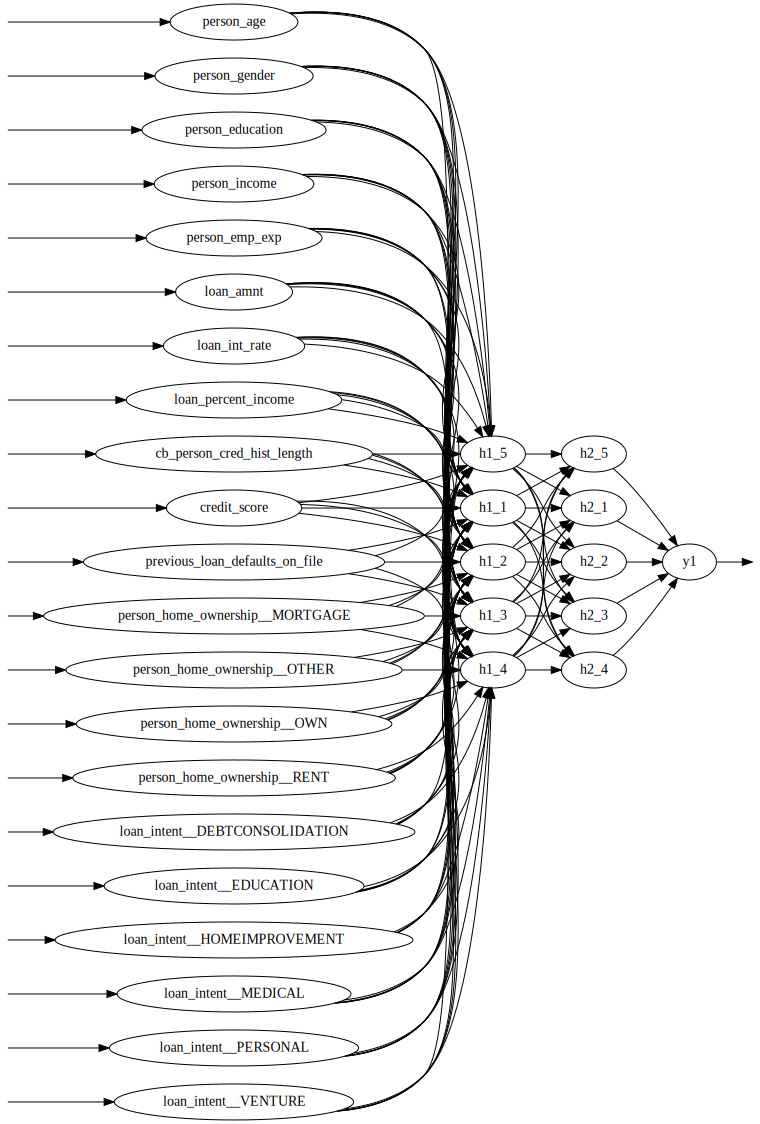

In [68]:
draw_network(X_train.shape[1], 5, 1, input_names=X.columns)

### <font color="#CA3532">Hagamos selección de atributos según los pesos</font>

Intentemos hacer selección de atributos según los pesos de la red...

Esperad. Ahora no tenemos una matriz de pesos $\mathbf{W}$, sino que tenemos **tres matrices** $\mathbf{W}^{h1}$, $\mathbf{W}^{h2}$ y $\mathbf{W}^y$. ¿Qué hacemos?

Vamos a pensar... Una entrada está conectada a muchas neuronas en la capa oculta.

¿Y si consideramos la suma de pesos como **cómo influye la entrada en total a todas las neuronas de la capa oculta**?

$$R_{xi} = \sum_j |W^{h1}_{ij}|$$

Esto se conoce como **relevancia global de los atributos de entrada según los pesos en valor absoluto**. Nos ayuda a entender cómo cada entrada influye en general en el modelo.

In [69]:
def global_relevance(model):
    w = model.layers[1].weights[0]
    R = np.abs(w).sum(axis=1)
    return R

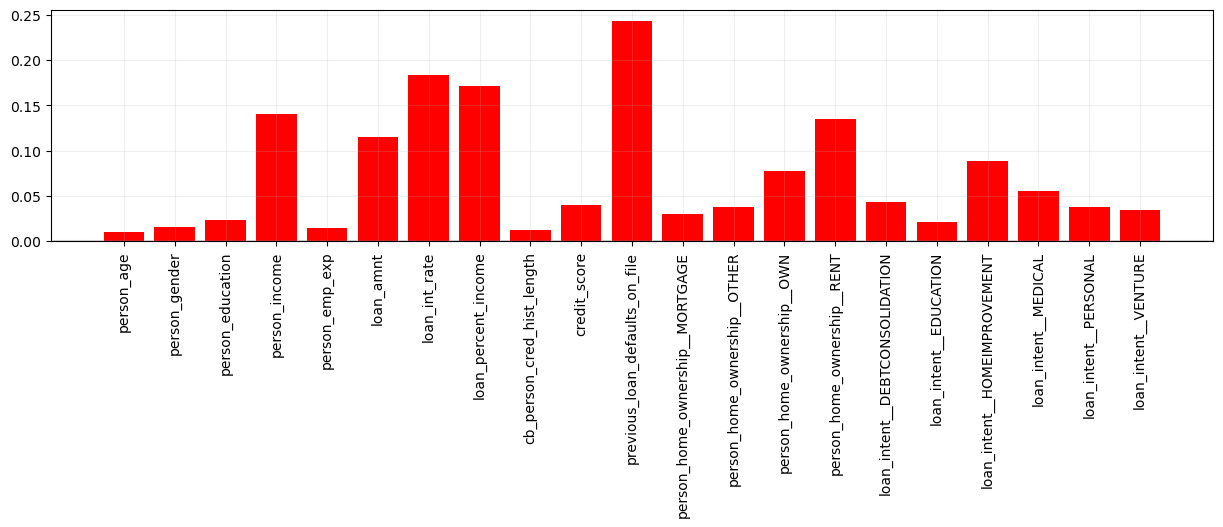

In [70]:
R = global_relevance(model)

plt.figure(figsize=(15, 3))
plt.bar(range(X_train.shape[1]), R, color="red")
plt.xticks(range(X_train.shape[1]), X.columns, rotation=90)
plt.grid(alpha=0.2)
plt.axhline(0.0, color="gray", alpha=0.3)
plt.show()

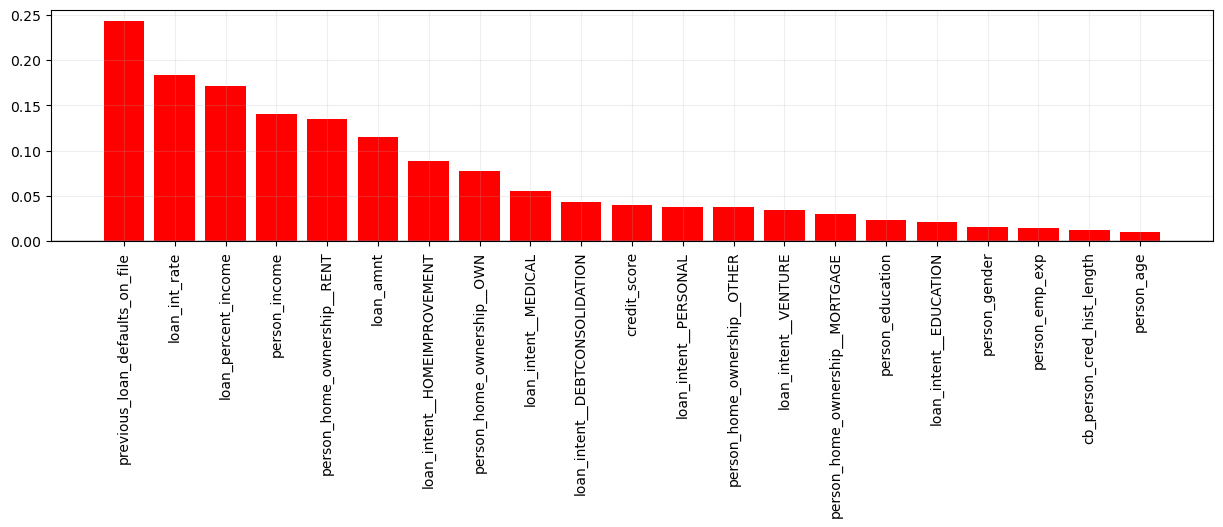

In [71]:
df = pd.DataFrame(R, index=X.columns, columns=["R"])
df = df.sort_values(by="R", ascending=False)
plt.figure(figsize=(15, 3))
plt.bar(range(len(df)), df["R"], color="red")
plt.xticks(range(len(df)), df.index, rotation=90)
plt.grid(alpha=0.2)
plt.axhline(0.0, color="gray", alpha=0.3)
plt.show()

###  <font color="#CA3532">Hagamos explicabilidad de la red según la derivada</font>

Recordad que para la explicabilidad de cualquier modelo basado en redes neuronales, una opción es calcularla a partir de sus gradientes (**Gradient x Input**). 

- Si quieres decir qué atributos han sido relevantes para tomar la decisión para la clase $y_c$:

$$R_{\mathbf{x}}^c = \mathbf{x} \cdot \nabla_\mathbf{x}(y_c)$$

- Si quieres explicar cómo se va a comportar el modelo para cada clase $y_c$:

$$R_{\mathbf{x}}^c = |\mathbf{x}| \cdot \nabla_\mathbf{x}(y_c)$$

In [72]:
def grad_x_input(x, model, relevancia=True, class_to_explain=0):
    with tf.GradientTape(persistent=True) as tape:
        x = tf.convert_to_tensor(x)
        tape.watch(x)
        y = model(x)
        y = y[:, class_to_explain]
        
    grad = tape.gradient(y, x)
    
    if relevancia:
        return (x * grad).numpy()
    else:
        return (np.abs(x) * grad).numpy()

In [73]:
R = grad_x_input(X_train, model, relevancia=True, class_to_explain=1)
R.shape

(36000, 21)

1/1 [==============================] - 0s 15ms/step


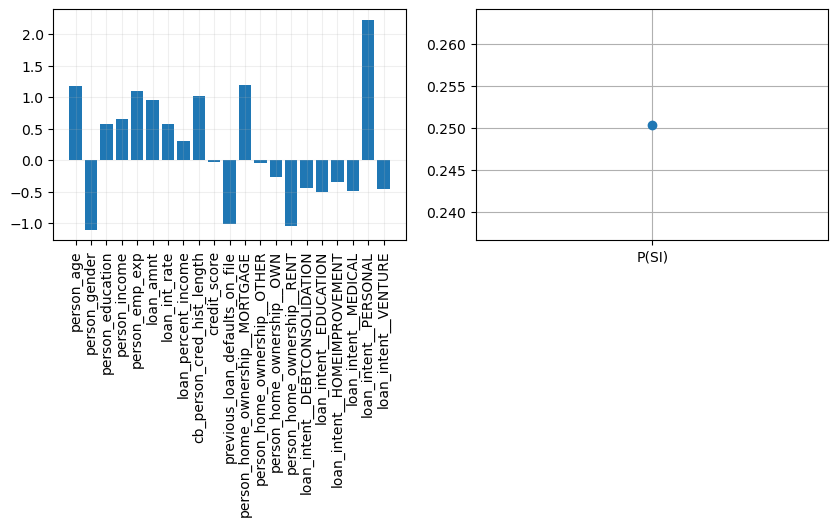

In [75]:
item = 0 # Modificar esta variable para evaluar otros ejemplos

ypred_real = model.predict(X_train.values[item][None, :])[0, 1]

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.bar(range(X_train.shape[1]), X_train.values[item])
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.grid(alpha=0.2)
plt.subplot(1,2,2)
plt.plot(ypred_real, 'o', label="Predicción real")
plt.xticks([0], ["P(SI)"])
plt.grid()
plt.show()

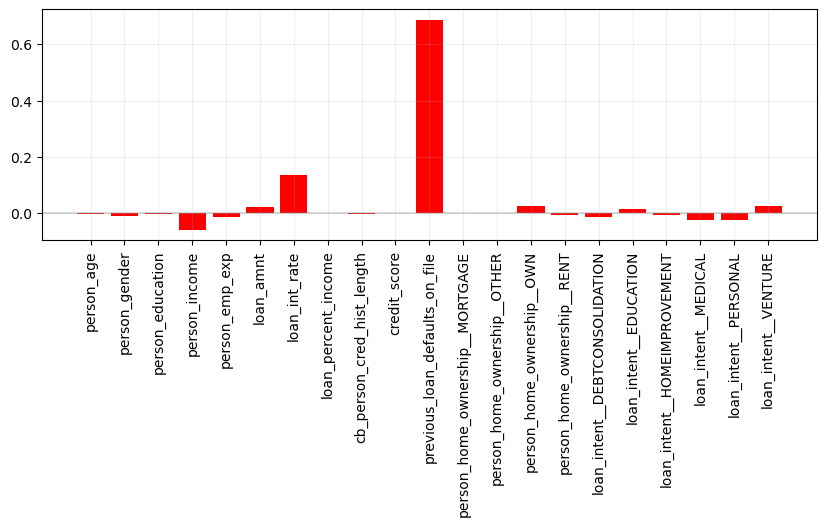

In [76]:
plt.figure(figsize=(10, 3))
plt.bar(range(X_train.shape[1]), R[item], color="red")
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.grid(alpha=0.2)
plt.axhline(0.0, color="gray", alpha=0.3)
plt.show()

In [77]:
from ipywidgets import interact, interactive, FloatSlider, VBox, Dropdown
import ipywidgets as widgets

In [78]:
one_hot_groups = {
    "person_home_ownership": ["person_home_ownership__MORTGAGE", 
                              "person_home_ownership__OTHER", 
                              "person_home_ownership__OWN", 
                              "person_home_ownership__RENT"],
    "loan_intent": ["loan_intent__DEBTCONSOLIDATION", 
                    "loan_intent__EDUCATION", 
                    "loan_intent__HOMEIMPROVEMENT", 
                    "loan_intent__MEDICAL", 
                    "loan_intent__PERSONAL", 
                    "loan_intent__VENTURE"]
}

x_original = X_train.values[item].copy()

# Creamos un diccionario de sliders (uno por variable)
sliders = {}
columnas_excluidas = {col for group in one_hot_groups.values() for col in group}

for col in X_train.columns:
    if col in columnas_excluidas:
        continue  # las dummies se gestionan aparte

    val = x_original[X_train.columns.get_loc(col)]
    col_min = X_train[col].min()
    col_max = X_train[col].max()
    delta = (col_max - col_min) * 0.1 or 0.1

    sliders[col] = FloatSlider(
        value=val,
        min=col_min - delta,
        max=col_max + delta,
        step=(col_max - col_min) / 100 or 0.01,
        description=col,
        continuous_update=False,
        layout=widgets.Layout(width='500px'),
        style={'description_width': '200px'}
    )

# Añadir dropdowns para las variables one-hot
for group_name, values in one_hot_groups.items():
    active_idx = np.argmax([x_original[X_train.columns.get_loc(v)] for v in values])
    sliders[group_name] = Dropdown(
        options=values,
        value=values[active_idx],
        description=group_name,
        layout=widgets.Layout(width='400px'),
        style={'description_width': '150px'}
    )

# Función que recibe los valores modificados
def actualizar_figura(**kwargs):
    x_mod = x_original.copy()

    # Actualizamos las variables numéricas
    for col in X_train.columns:
        if col in columnas_excluidas:
            continue
        idx = X_train.columns.get_loc(col)
        x_mod[idx] = kwargs[col]

    # Actualizamos las variables one-hot
    for group_name, values in one_hot_groups.items():
        seleccionada = kwargs[group_name]
        for val in values:
            idx = X_train.columns.get_loc(val)
            x_mod[idx] = X_train.iloc[:, idx].max() if val == seleccionada else X_train.iloc[:, idx].min()

    R = grad_x_input(x_original[None, :], model, relevancia=False, class_to_explain=1)[0]
    R_mod = grad_x_input(x_mod[None, :], model, relevancia=False, class_to_explain=1)[0]
    ypred_real = model.predict(x_original[None, :], verbose=0)[0, 1]
    ypred_mod = model.predict(x_mod[None, :], verbose=0)[0, 1]

    plt.figure(figsize=(10, 3))
    plt.bar(range(X_train.shape[1]), R[item], label="Original", alpha=0.6)
    plt.bar(range(X_train.shape[1]), R_mod, label="Modificado", alpha=0.6)
    plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
    plt.grid(alpha=0.2)
    plt.axhline(0.0, color="gray", alpha=0.3)
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.bar(range(len(x_original)), x_original, label='Original', alpha=0.6)
    plt.bar(range(len(x_mod)), x_mod, label='Modificado', alpha=0.6)
    plt.xticks(range(len(x_original)), X_train.columns, rotation=90)
    plt.grid(alpha=0.2)
    plt.title(f"Entradas del modelo (item #{item})")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot([0], [ypred_real], 'o', label="Original")
    plt.plot([0], [ypred_mod], 'o', label="Modificado")
    plt.xticks([0], ["P(SI)"])
    plt.ylim(0, 1)
    plt.grid()
    plt.title("Predicción del modelo")
    plt.legend()
    plt.axhline(0.5, color="green", alpha=0.7)

    plt.tight_layout()
    plt.show()

# Mostrar la interfaz interactiva
out = interactive(actualizar_figura, **sliders)
display(out)


interactive(children=(FloatSlider(value=1.1824882798775387, continuous_update=False, description='person_age',…